### Transfer Learning MobileNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../files_detour.csv',index_col=0)

In [3]:
src_img = '../images_detour/'

In [4]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [5]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [6]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [7]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour/BA_102750.jpg,BA_102750.jpg,basophil,0


In [8]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [9]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) # format nécessaire pour MobileNet
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

In [10]:
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [12]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [13]:
# Création d'un modèle MobileNet
def model_mobileNet():
    base_model = MobileNet(
        weights='imagenet',  
        input_shape=(224, 224, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.5)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = model_mobileNet()

In [15]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 791s 989ms/step - loss: 0.9989 - accuracy: 0.6702 - val_loss: 0.5260 - val_accuracy: 0.8387
Epoch 2/16
800/800 [==============================] - 815s 1s/step - loss: 0.6965 - accuracy: 0.7786 - val_loss: 0.4688 - val_accuracy: 0.8587
Epoch 3/16
800/800 [==============================] - 792s 990ms/step - loss: 0.6282 - accuracy: 0.8035 - val_loss: 0.4806 - val_accuracy: 0.8425
Epoch 4/16
800/800 [==============================] - 781s 976ms/step - loss: 0.5987 - accuracy: 0.8165 - val_loss: 0.4447 - val_accuracy: 0.8583
Epoch 5/16
800/800 [==============================] - 780s 975ms/step - loss: 0.5751 - accuracy: 0.8235 - val_loss: 0.4189 - val_accuracy: 0.8591
Epoch 6/16
800/800 [==============================] - 804s 1s/step - loss: 0.5490 - accuracy: 0.8297 - val_loss: 0.4165 - val_accuracy: 0.8731
Epoch 7/16
800/800 [==============================] - 849s 1s/step - loss: 0.5342 - accuracy: 0.8356 - val_loss: 0.4454 - val_accu

In [16]:
model.save_weights("mobilenet_detour_weights")

#### Prédiction sur les données d'évaluation

In [ ]:
# model = model_mobileNet()
# model.load_weights("mobilenet_detour_weights")

In [17]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [18]:
model.evaluate(dataset_eval)

99/99 [==============================] - 122s 1s/step - loss: 0.4343 - accuracy: 0.8605


[0.43426233530044556, 0.860487163066864]

 * Score 86%, plus faible que sans détourage

In [19]:
#Classes prédites
predict = model.predict(dataset_eval)

In [20]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.82      0.91      0.86       119
       blast       0.77      0.90      0.83       327
  eosinophil       0.97      0.90      0.93       323
erythroblast       0.86      0.94      0.90       210
          ig       0.80      0.66      0.72       381
  lymphocyte       0.90      0.87      0.89       453
    monocyte       0.78      0.78      0.78       274
  neutrophil       0.88      0.95      0.91       573
    platelet       0.99      1.00      0.99       242
      smudge       0.81      0.69      0.75       259

    accuracy                           0.86      3161
   macro avg       0.86      0.86      0.86      3161
weighted avg       0.86      0.86      0.86      3161



> Rappel plus faible sur les IG toujours, ainsi que les monocytes
>
> Score plus faible sur blast et smudge, compréhensible par des différences importantes sur ces types

In [21]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,108,1,1,0,4,1,1,3,0,0
blast,0,294,0,0,5,6,12,0,0,10
eosinophil,0,0,292,1,3,0,0,25,1,1
erythroblast,0,0,0,198,3,6,0,2,1,0
ig,13,47,2,4,251,5,20,27,0,12
lymphocyte,7,12,0,19,5,396,8,0,0,6
monocyte,0,15,0,1,21,4,215,6,0,12
neutrophil,0,1,5,4,9,3,6,545,0,0
platelet,0,0,0,0,0,0,0,0,241,1


> Confusion importante blaste/IG ainsi que monocyte/IG

In [22]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [23]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

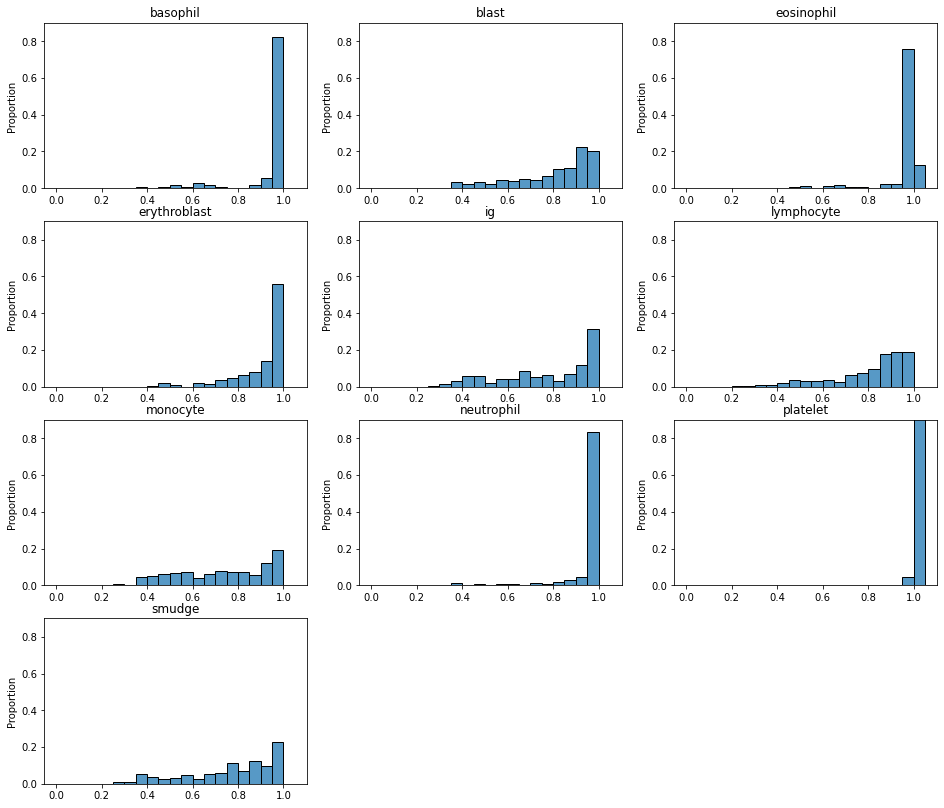

In [24]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Les prédictions sont faites avec un pourcentage de confiance supérieur à 80% pour tous les types sauf les blastes

In [25]:
# Récupère les cellules mal prédites => regarde la proba sur la classe prédite
predict_no_correct = compare[compare['Réalité']!=compare['Prédiction']]

In [26]:
predict_by_class = []
for i in range(10):
    indexes = predict_no_correct[predict_no_correct['Prédiction']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

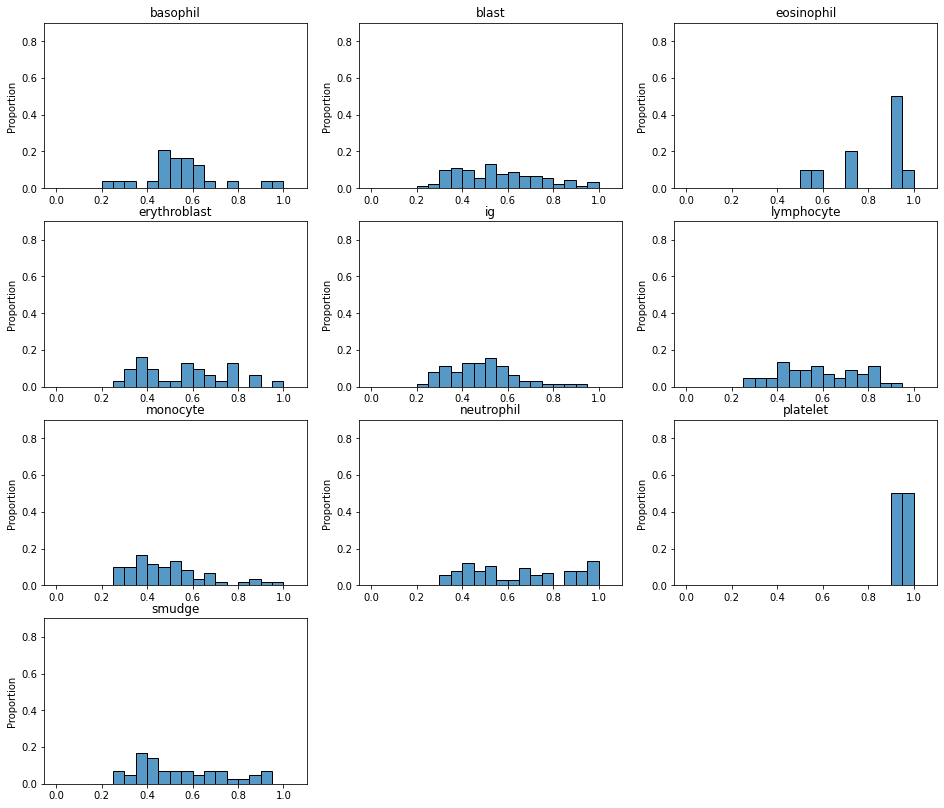

In [27]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Sur les cellules avec erreurs de classes, le pourcentage sur la classe erronée est cependant important


### GRAD CAM

In [28]:
import gradcam_dataset

In [29]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [98]:
img_size = (255, 255)
last_conv_layer_name = "conv_pw_13_relu"

##### BASOPHIL

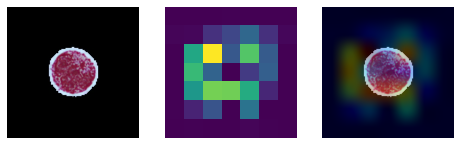

In [99]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

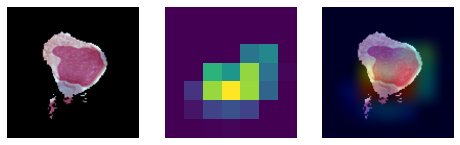

In [100]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

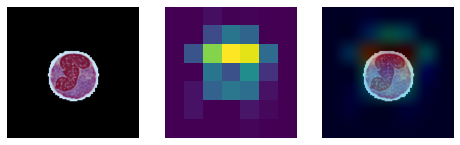

In [101]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

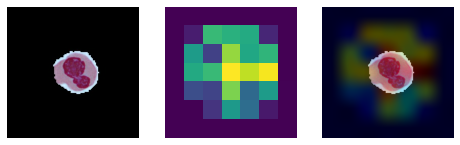

In [102]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

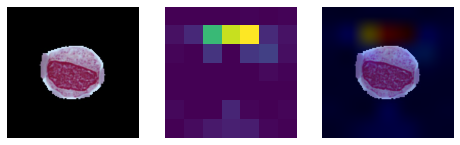

In [103]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

Cellule non prédite dans la catégorie attendue


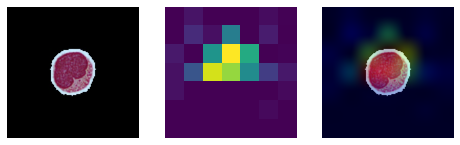

In [104]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

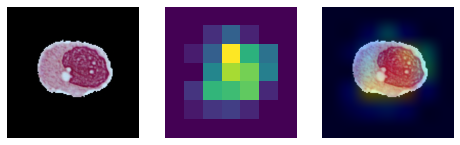

In [105]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

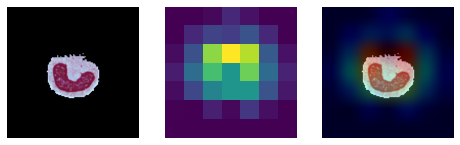

In [106]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

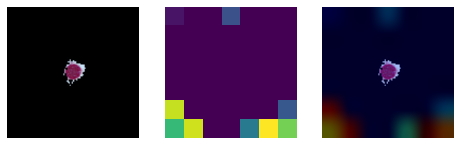

In [107]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

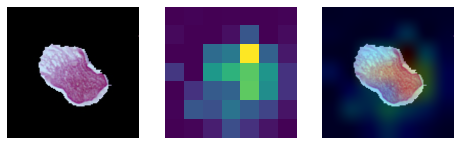

In [108]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)

> Prise en compte de zone en dehors de la cellule pour certains types, pas de réelles améliorations avec le détourage
>
> Problème d'analyse????